In [535]:
import networkx as nx
import cirq
import cirq_google
import numpy as np
from matplotlib import pyplot as plt

In [491]:
class Gate:
    def __init__(self, gname, *args):
        self.name = gname
        self.qs = []
        for i in args:
            self.qs.append(i)
    
    def apply(self, *qubits):
        return getattr(cirq, self.name)(qubits)

### Generate Gate Sequence

In [712]:
num_q = 5
depth = 5
oneq_gates = ["T", "rx", "ry"]
inv_prob = [len(oneq_gates) for i in range(len(oneq_gates))]
gates = []

nodes = []

for i in range(num_q):
    gates.append(Gate("H", i))
    nodes.append((i, {"subset" : 0}))

cnt = num_q
for i in range(depth):
    lst = [i for i in range(num_q - 1)]
    lst_fin = []
    while len(lst) > 0:
        v = np.random.choice(lst)
        lst_fin.append(v)
        lst.remove(v)
        if (v + 1) in lst:
            lst.remove(v + 1)
        if (v - 1) in lst:
            lst.remove(v - 1)
    lst_fin = np.sort(lst_fin)
    for v in range(num_q):
        if v in lst_fin:
            gates.append(Gate("CZ", v, v + 1))
            nodes.append((cnt, {"subset" : 2 * i + 1}))
            cnt += 1
        elif v not in lst_fin and v not in lst_fin + 1:
            gates.append(Gate(""))
            nodes.append((cnt, {"subset" : 2 * i + 1}))
            cnt += 1

    gate = np.random.choice(oneq_gates, p = np.array([1. / i for i in inv_prob]) / sum([1. / i for i in inv_prob]))
    inv_prob[oneq_gates.index(gate)] += len(oneq_gates)
    for j in range(num_q):
        gates.append(Gate(gate, j))
        nodes.append((cnt, {"subset" : 2 * i + 2}))
        cnt += 1

In [713]:
# for g in gates:
#     print(g.name, g.qs)

### Create Graph

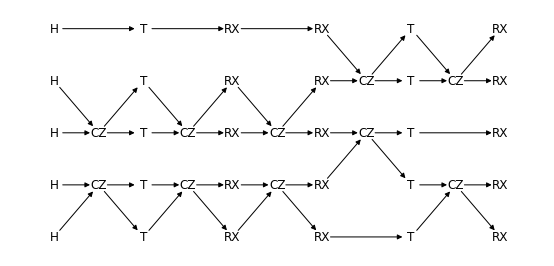

In [714]:
G = nx.DiGraph()
G.add_nodes_from(nodes)

cur_gate = np.array([i for i in range(num_q)])
cur = num_q
for gate in gates[num_q:]:
    for i in gate.qs:
        G.add_edge(cur_gate[i], cur)
        cur_gate[i] = cur
    cur += 1
    
pos = nx.multipartite_layout(G)
labeldict = {}
for i in range(len(gates)):
    labeldict[i] = gates[i].name.upper()
nx.draw(G, pos, labels = labeldict, with_labels = True, node_color = 'none')

### Simulate on LineQubit

In [715]:
q_line = cirq.LineQubit.range(num_q)
line_circuit = cirq.Circuit()

for gate in gates:        
    if len(gate.qs) == 1 and gate.name[0] != 'r':
        line_circuit.append(getattr(cirq, gate.name)(q_line[gate.qs[0]]))
    elif len(gate.qs) == 1:
        line_circuit.append(getattr(cirq, gate.name)(np.pi / 2)(q_line[gate.qs[0]]))
    elif len(gate.qs) == 2:
        line_circuit.append(getattr(cirq, gate.name)(q_line[gate.qs[0]], q_line[gate.qs[1]]))
print(line_circuit)
#barier

0: ───H───T───Rx(0.5π)───Rx(0.5π)─────────────────────────────@───T───@──────────Rx(0.5π)───
                                                              │       │
1: ───H───@───T──────────@──────────Rx(0.5π)───@───Rx(0.5π)───@───T───@──────────Rx(0.5π)───
          │              │                     │
2: ───H───@───T──────────@──────────Rx(0.5π)───@───Rx(0.5π)───@───T───Rx(0.5π)──────────────
                                                              │
3: ───H───@───T──────────@──────────Rx(0.5π)───@───Rx(0.5π)───@───T───@──────────Rx(0.5π)───
          │              │                     │                      │
4: ───H───@───T──────────@──────────Rx(0.5π)───@───Rx(0.5π)───T───────@──────────Rx(0.5π)───


In [716]:
sim = cirq.Simulator()
results_line = sim.simulate(line_circuit)
print(results_line)

measurements: (no measurements)
output vector: [ 1.5088828e-01+0.10669415j -8.8388301e-02-0.10669412j
 -1.5088828e-01+0.04419415j  5.5879354e-09-0.16919409j
  8.8388294e-02-0.10669411j  1.5088825e-01-0.10669412j
  1.3038516e-08-0.16919407j -1.5088826e-01-0.04419415j
  2.0266493e-01+0.04419417j  3.7252903e-09-0.16919409j
 -1.5088826e-01-0.05491742j -8.8388279e-02-0.1950824j
  1.1175871e-08-0.1691941j   2.0266491e-01-0.04419415j
  8.8388301e-02-0.1950824j  -1.5088826e-01+0.05491745j
  1.5088826e-01+0.10669414j -8.8388316e-02-0.10669413j
 -1.5088829e-01+0.04419414j  1.8626451e-09-0.16919407j
  8.8388309e-02-0.10669411j  1.5088828e-01-0.10669415j
  5.5879354e-09-0.16919409j -1.5088828e-01-0.04419417j
  2.0266491e-01+0.04419415j  1.3038516e-08-0.1691941j
 -1.5088826e-01-0.05491745j -8.8388301e-02-0.1950824j
 -7.4505806e-09-0.16919409j  2.0266493e-01-0.04419415j
  8.8388294e-02-0.1950824j  -1.5088826e-01+0.05491746j]


### Simulate with Swaps

In [717]:
q_cross = []
#В начале в центре первый кубит (можем применять CZ на пары (0,1) и (1,2)), при необходимости меняем его и третий (получаем оставшиеся пары (2,3) и (3,4))
q_cross.append(cirq.GridQubit(0, 1))    #qubit 0
q_cross.append(cirq.GridQubit(1, 1))    #qubit 1
q_cross.append(cirq.GridQubit(1, 0))    #qubit 2
q_cross.append(cirq.GridQubit(1, 2))    #qubit 3
q_cross.append(cirq.GridQubit(2, 1))    #qubit 4

cross_circuit = cirq.Circuit()
current = 1

for gate in gates:        
    if len(gate.qs) == 1 and gate.name[0] != 'r':
        cross_circuit.append(getattr(cirq, gate.name)(q_cross[gate.qs[0]]))
    elif len(gate.qs) == 1:
        cross_circuit.append(getattr(cirq, gate.name)(np.pi / 2)(q_cross[gate.qs[0]]))
    elif len(gate.qs) == 2:
        if 3 in gate.qs and current == 1:
            qb = gate.qs[1 - gate.qs.index(3)]
            cross_circuit.append(cirq.SWAP(q_cross[1], q_cross[3]))
            current = 3
        elif 1 in gate.qs and current == 3:
            qb = gate.qs[1 - gate.qs.index(1)]
            cross_circuit.append(cirq.SWAP(q_cross[1], q_cross[3]))
            current = 1
        else:
            qb = gate.qs[1 - gate.qs.index(current)]
        cross_circuit.append(getattr(cirq, gate.name)(q_cross[1], q_cross[qb]))
if current == 3:
    cross_circuit.append(cirq.SWAP(q_cross[1], q_cross[3]))
cross_circuit.append(cirq.SWAP(q_cross[1], q_cross[2]))
print(cross_circuit)

                              ┌─────────┐                          ┌─────────┐                                 ┌─────────┐                                                            ┌─────────┐
(0, 1): ───H───T───Rx(0.5π)────Rx(0.5π)─────────────────────────────────────────────────────────────────────────────────────────────────────@───T──────────────────────@───Rx(0.5π)────────────────────────────────────
                                                                                                                                            │                          │
(1, 0): ───H───@───T────────────────────────────────@───Rx(0.5π)────────────────────────────────@───Rx(0.5π)────────────────────────────────┼───────@───T───Rx(0.5π)───┼───────────────────────────────────────────×───
               │                                    │                                           │                                           │       │                  │                                     

In [718]:
sim_cross = cirq.Simulator()
results_cross = sim_cross.simulate(cross_circuit)
print(results_cross)

measurements: (no measurements)
output vector: [ 1.5088825e-01+0.10669415j -8.8388264e-02-0.10669412j
 -1.5088826e-01+0.04419413j  3.7252903e-09-0.16919407j
  8.8388309e-02-0.1066941j   1.5088826e-01-0.1066941j
  2.6077032e-08-0.16919406j -1.5088828e-01-0.04419415j
  2.0266493e-01+0.04419418j  1.6763806e-08-0.16919409j
 -1.5088825e-01-0.05491747j -8.8388324e-02-0.19508241j
  1.8626451e-09-0.1691941j   2.0266491e-01-0.04419414j
  8.8388331e-02-0.19508238j -1.5088828e-01+0.05491746j
  1.5088826e-01+0.10669412j -8.8388294e-02-0.1066941j
 -1.5088826e-01+0.04419415j -1.3038516e-08-0.16919407j
  8.8388279e-02-0.1066941j   1.5088826e-01-0.10669413j
  7.4505806e-09-0.16919407j -1.5088826e-01-0.04419415j
  2.0266494e-01+0.04419415j  3.1664968e-08-0.16919407j
 -1.5088825e-01-0.05491746j -8.8388339e-02-0.19508241j
 -4.0978193e-08-0.1691941j   2.0266491e-01-0.04419416j
  8.8388309e-02-0.1950824j  -1.5088826e-01+0.0549175j ]


### Results comparison

In [719]:
np.round(results_line.final_state_vector - results_cross.final_state_vector, 3)
#Результаты одинаковые

array([ 0.+0.j, -0.+0.j, -0.+0.j,  0.-0.j, -0.-0.j, -0.-0.j, -0.-0.j,
        0.+0.j,  0.-0.j, -0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,  0.-0.j,
       -0.-0.j,  0.-0.j,  0.+0.j, -0.-0.j, -0.-0.j,  0.+0.j,  0.-0.j,
        0.-0.j, -0.-0.j, -0.-0.j, -0.+0.j, -0.-0.j, -0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j, -0.+0.j,  0.-0.j], dtype=complex64)